# Dogs-Breed-Classification

#### Imports

In [100]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
import os
import PIL
import tensorflow as tf
import math
import cv2
import pydot
import pandas as pd
import random
from glob import glob

from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.models import Sequential
from keras import callbacks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model,image_dataset_from_directory
import random as rn
from random import shuffle
from PIL import Image
from IPython.display import SVG
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Activation, Dropout, Flatten, Dense

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Set the main path

In [5]:
path = "C:/Users/Asus/Data Science Project/Dataset after iqr/"
train_data_dir = path #input the path of father directory

#### Create ImageDataGenerator - Split the data into train and validation

In [7]:
img_height=150
img_width=150
batch_size=32

num_of_classes=11 #input number of breeds you want to classify

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10, # rotation
    width_shift_range=0.2, # horizontal shift
    height_shift_range=0.2, # vertical shift
    zoom_range=0.2, # zoom
    horizontal_flip=True, # horizontal flip
    brightness_range=[0.2,1.2],
    validation_split=0.2) # set validation split
                      
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation') # set as validation data

Found 55028 images belonging to 11 classes.
Found 13750 images belonging to 11 classes.


#### Optional - Load weights from the last model fit

In [ ]:
#model.load_weights(train_data_dir +'/weights.best.from_scratch.hdf5')

## Convolutional neural network - Model

In [9]:
model=Sequential()
model.add(Conv2D(filters = 32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512)) #fully connected layer => Neural Network
model.add(Activation('relu')) 
model.add(Dropout(0.2))
model.add(Dense(num_of_classes,activation="softmax")) 

model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

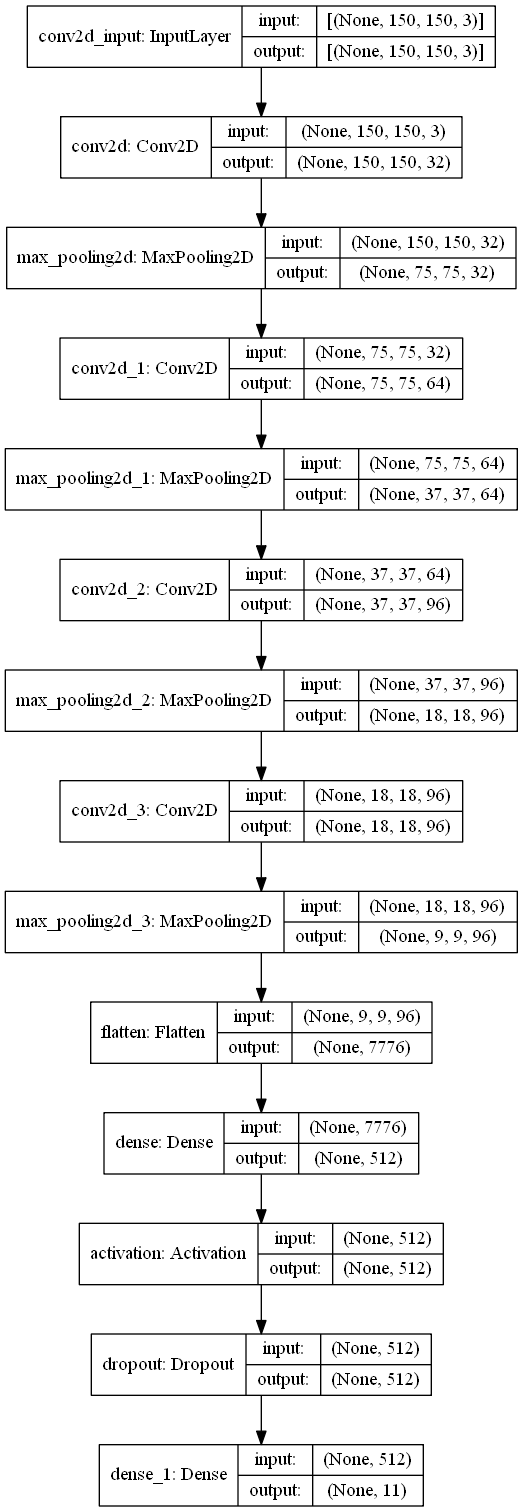

In [158]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

#### CNN Callbacks - ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [14]:
checkpoint_path = train_data_dir +'/weights.best.from_scratch.hdf5'

checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)

red_lr = ReduceLROnPlateau( 
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="auto", 
    min_delta=0.0001, 
    cooldown=0, min_lr=0
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=5,
    verbose=1,
    mode='auto'
)

callbacks = [checkpointer, earlystop, red_lr]

#### Fit model 

In [16]:
history=model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 50,
    callbacks=callbacks)

Epoch 1/50
1719/1719 [==============================] - 1565s 910ms/step - loss: 2.0982 - accuracy: 0.2634 - val_loss: 1.8783 - val_accuracy: 0.3413

Epoch 00001: val_loss improved from inf to 1.87826, saving model to C:/Users/Asus/Data Science Project/Dataset after iqr\weights.best.from_scratch.hdf5
Epoch 2/50
1719/1719 [==============================] - 1163s 676ms/step - loss: 1.7673 - accuracy: 0.3967 - val_loss: 1.5543 - val_accuracy: 0.4765

Epoch 00002: val_loss improved from 1.87826 to 1.55432, saving model to C:/Users/Asus/Data Science Project/Dataset after iqr\weights.best.from_scratch.hdf5
Epoch 3/50
1719/1719 [==============================] - 1147s 667ms/step - loss: 1.5423 - accuracy: 0.4835 - val_loss: 1.3585 - val_accuracy: 0.5457

Epoch 00003: val_loss improved from 1.55432 to 1.35850, saving model to C:/Users/Asus/Data Science Project/Dataset after iqr\weights.best.from_scratch.hdf5
Epoch 4/50
1719/1719 [==============================] - 1150s 669ms/step - loss: 1.413

In [8]:
model.load_weights(checkpoint_path)

#### Model evaluation plot

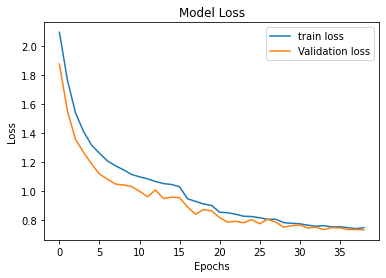

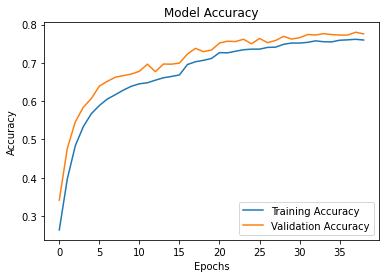

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss','Validation loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.savefig('baseline_loss_epoch.jpg', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.savefig('baseline_acc_epoch.jpg', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

#### Model prediction

In [160]:
pred=model.predict(validation_generator,verbose=1)

430/430 [==============================] - 163s 378ms/step


#### Optional - inspect the prediction, each value in list indicites class accuracy  in the test

In [318]:
#print(pred)

### Preparing the prediction data for the Confusion-Matrix

In [162]:
predicted_class_indices=np.argmax(pred,axis=1)

In [163]:
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [164]:
labels_cm = set(predictions) 
labels_cm = list(labels_cm)
labels_cm.sort()

In [165]:
filenames=validation_generator.filenames
results=pd.DataFrame({"Filename":filenames,"Predictions":predictions})

#### Get the data from the results DataFrame

##### correct_labels - y_true - the real label of certain image

In [166]:
correct_labels = []

for ind in results.index:
    cur_class = results['Filename'][ind].split('\\',maxsplit=1)
    correct_labels.append(cur_class[0])

##### predictions_labels - y_pred - the prediction of certain image respectively

In [167]:
predictions_labels = results['Predictions'].tolist()

#### test_accuracy - check if the prediction accuracy matches the validation accuracy from the fit results 

In [168]:
#Get the accuracy from the prediction model
test_accuracy = np.sum(np.array(correct_labels)==np.array(predictions_labels))/len(correct_labels)*100
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 77.5927%


#### Create the Confusion-Matrix

In [169]:
y_true = correct_labels
y_pred = predictions_labels
labels = labels_cm

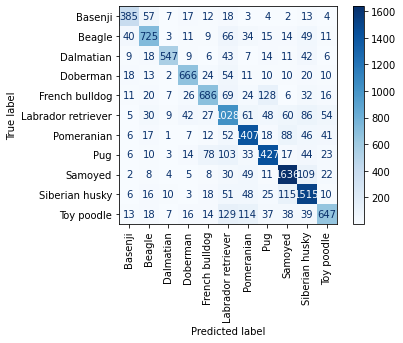

In [170]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels = labels)
disp.plot(cmap = plt.cm.Blues, xticks_rotation = 90)
plt.show()

In [171]:
df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred))
df_cm

0    1    2    3    4     5     6     7     8     9    10
0   385   57    7   17   12    18     3     4     2    13    4
1    40  725    3   11    9    66    34    15    14    49   11
2     9   18  547    9    6    43     7    14    11    42    6
3    18   13    2  666   24    54    11    10    10    20   10
4    11   20    7   26  686    69    24   128     6    32   16
5     5   30    9   42   27  1028    61    48    60    86   54
6     6   17    1    7   12    52  1407    18    88    46   41
7     6   10    3   14   78   103    33  1427    17    44   23
8     2    8    4    5    8    30    49    11  1636   109   22
9     6   16   10    3   18    51    48    25   115  1515   10
10   13   18    7   16   14   129   114    37    38    39  647

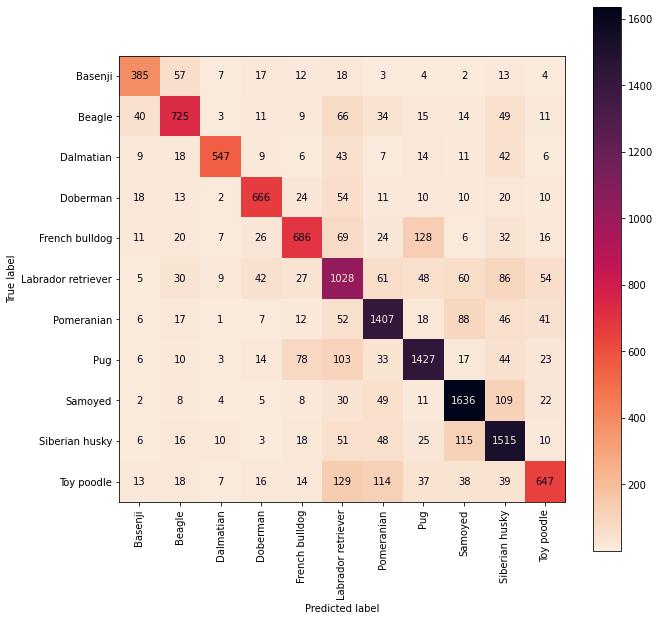

In [172]:
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,xticks_rotation=90,cmap="rocket_r")

In [173]:
plt.savefig('ConfusionMatrix.jpg')

<Figure size 432x288 with 0 Axes>

### Model predictions - plots view

#### Create figure with plots to present model's prediction in action

In [184]:
def display_15_images(paths,breeds,predictions):
    rows = 5
    columns = 3
    for j in range(3):
        fig = plt.figure(figsize=(20, 20), dpi=80)
        for i in range(15):
            rand_elt_num = random.randint(0, len(paths)-1 )
            Image = cv2.imread(paths[rand_elt_num])
            RGB_img = cv2.cvtColor(Image, cv2.COLOR_BGR2RGB)
            fig.add_subplot(rows, columns, i+1)
            plt.title(f"Model Prediction: {predictions[rand_elt_num]} \n True Breed: {breeds[rand_elt_num]}")
            plt.imshow(RGB_img)
            #plt.savefig('PRED {0}.jpg'.format(i))
        fig.tight_layout(pad=5.0)
        fig.savefig(f"model_predictions_{j+1}.jpg",bbox_inches='tight')

#### Create figure with plots to present model's prediction on single image

In [178]:
def display_image(path,breed,fig,r,c,cur_r):
    img= None
    img = keras.preprocessing.image.load_img(path, target_size=(150, 150))
    x = keras.preprocessing.image.img_to_array(img)
    image = np.expand_dims(x, axis=0)
    pred=model.predict(image,verbose=1)
    #predict the image as tensor
    predicted_class_indices=np.argmax(pred,axis=1)
    #plot the image using cv2
    image_cv = cv2.imread(path)
    RGB_img = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
    fig.add_subplot(r, c, cur_r)
    plt.title(f"Model Prediction: {labels_cm[int(predicted_class_indices)]} \n True Breed: {breed}")
    plt.savefig(f"model_predictions_{i+1}.jpg",bbox_inches='tight')
    ax = plt.imshow(RGB_img)
    fig.tight_layout(pad=0.5)
    return ax

In [181]:
base_path = "C:/Users/Asus/Data Science Project/Dataset after iqr/"

paths = [] 
image_breed = []
predictions = []

for index, row in results.iterrows():
    paths.append(row["Filename"])
    predictions.append(row["Predictions"])
    
for i,path in enumerate(paths):
    full_path = os.path.join(base_path,path)
    paths[i] = full_path

In [182]:
for path in paths:
    breed = path.rsplit('/',maxsplit=1)[1]
    breed = breed.split('\\')[0]
    image_breed.append(breed)

### Optional - test on my images

In [156]:
my_path = 'C:/Users/Asus/Data Science Project/My Images'
my_images = np.array(glob(f"{my_path}/*"))

my_image_breed = []

for path in my_images:
    breed = path.rsplit('/',maxsplit=1)[1]
    breed = breed.split('\\')[1]
    breed = breed.split('.')[0]
    breed = breed.split('POND')[0]
    my_image_breed.append(breed)

1/1 [==============================] - 0s 33ms/step


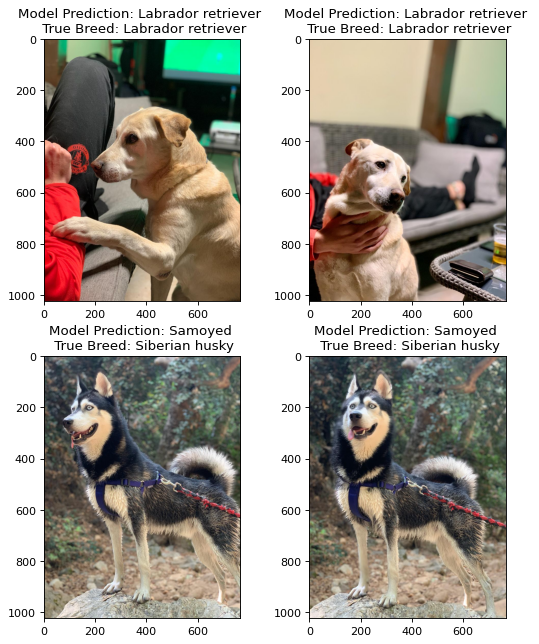

In [179]:
rows = int(len(my_images)/2)
columns = int(len(my_images)/2)
fig = plt.figure(figsize=(8, 8), dpi=80)

for i,path in enumerate(my_images):
    display_image(path,my_image_breed[i],fig,rows,columns,i+1)

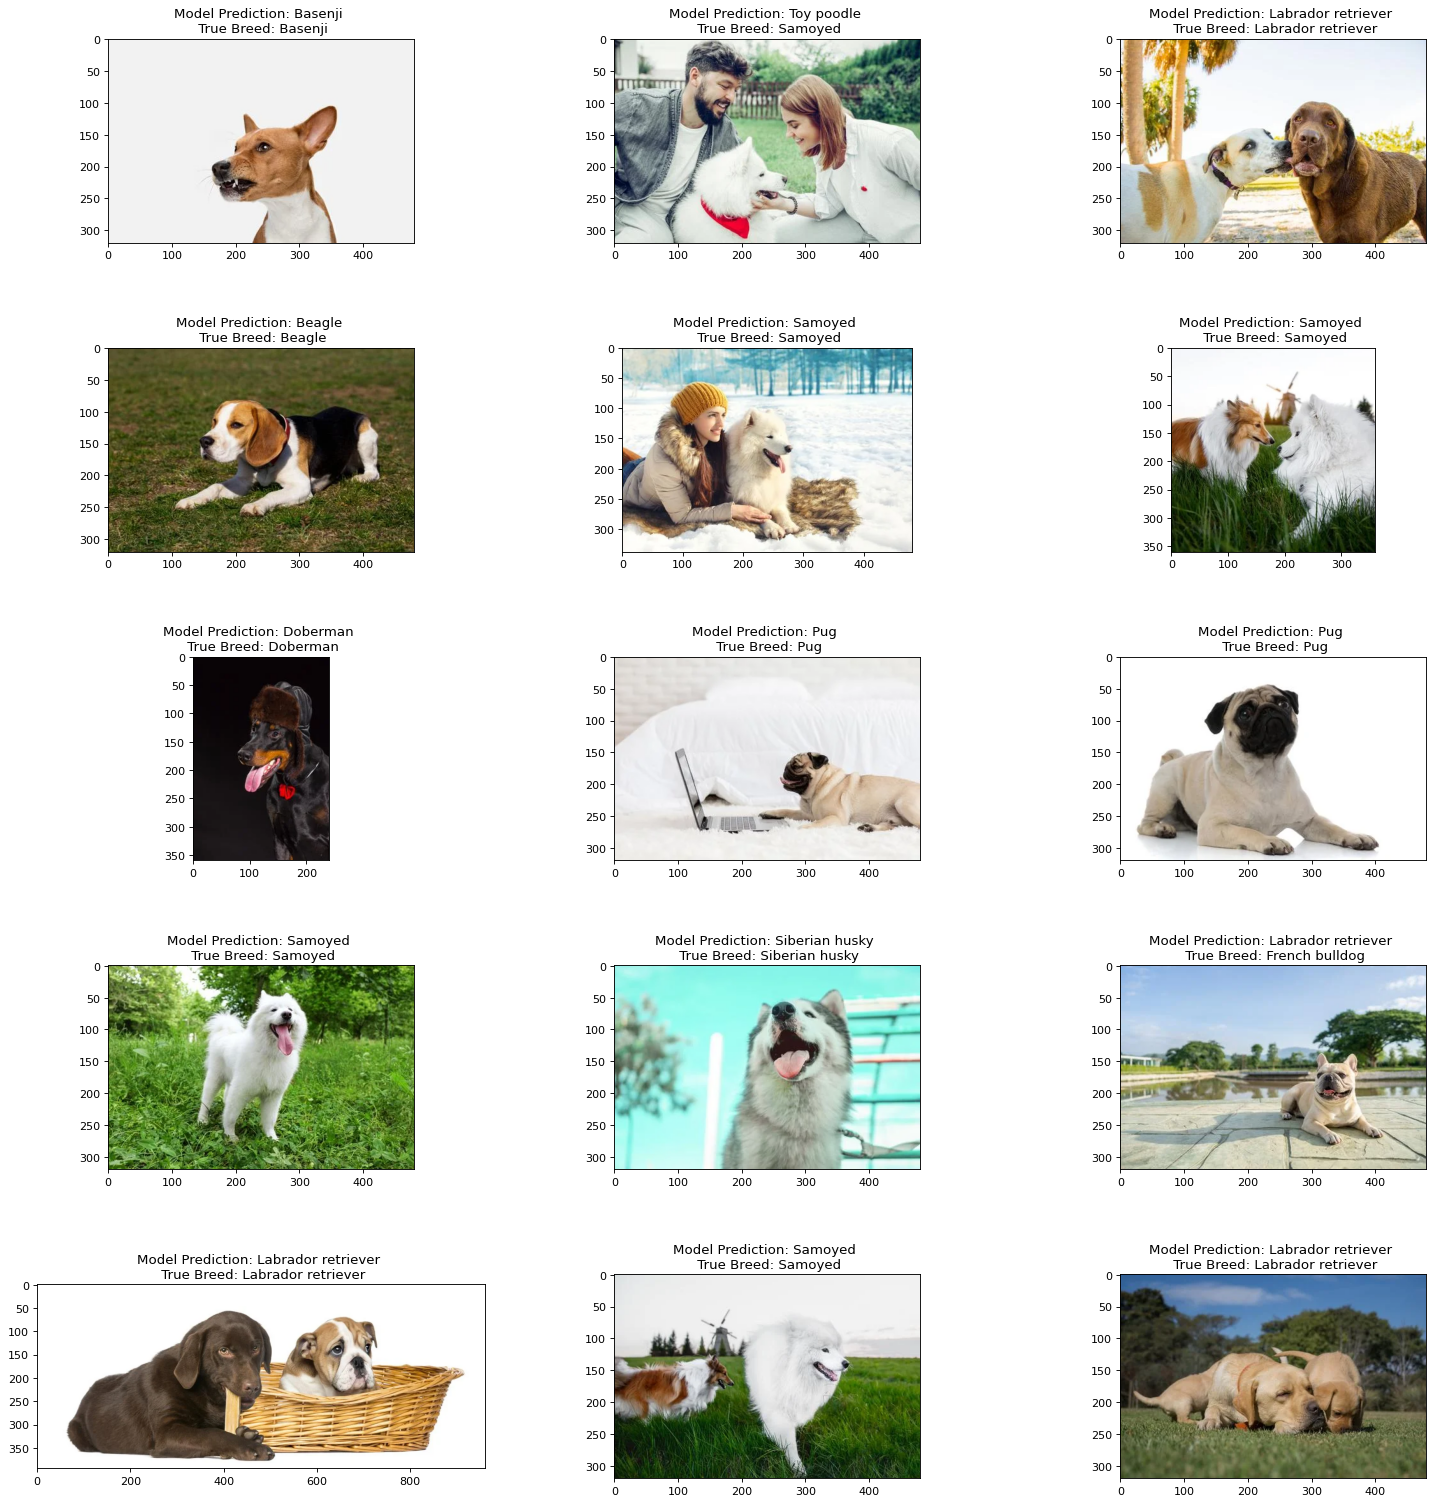

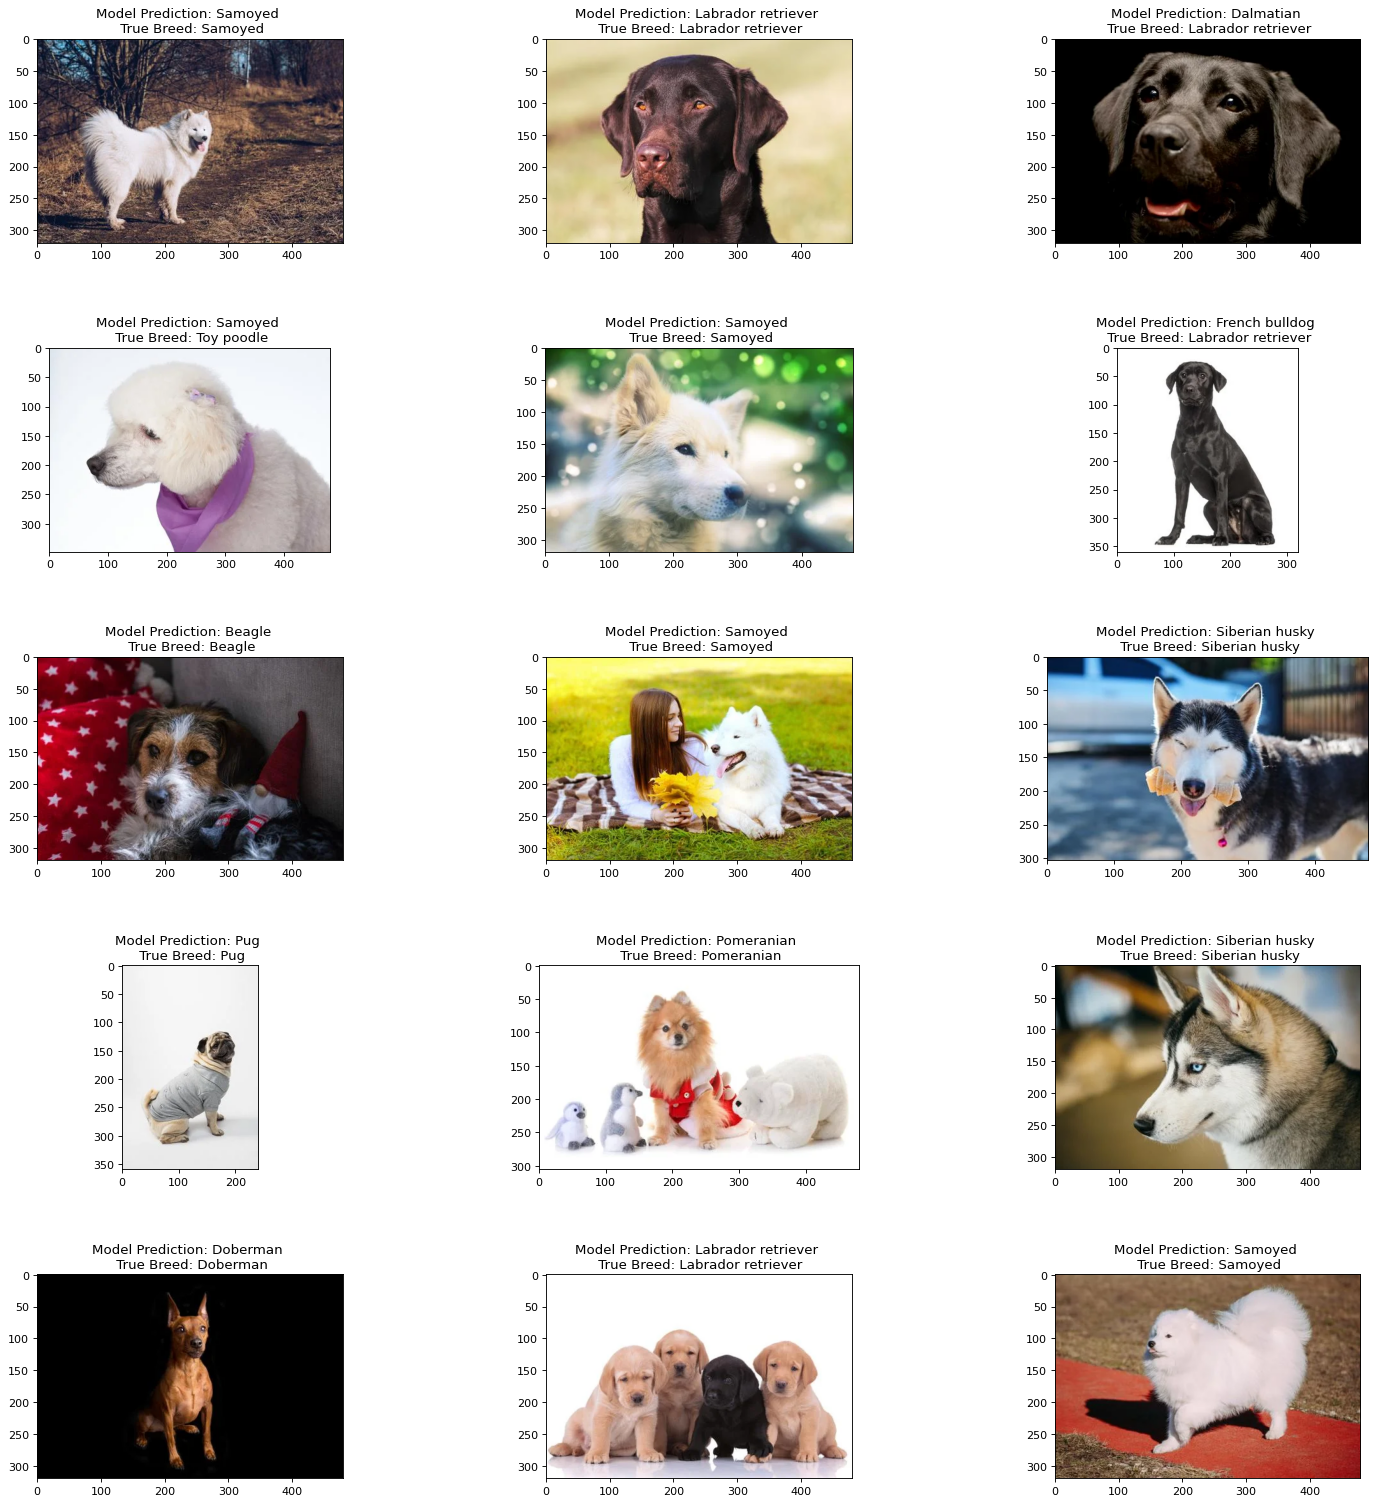

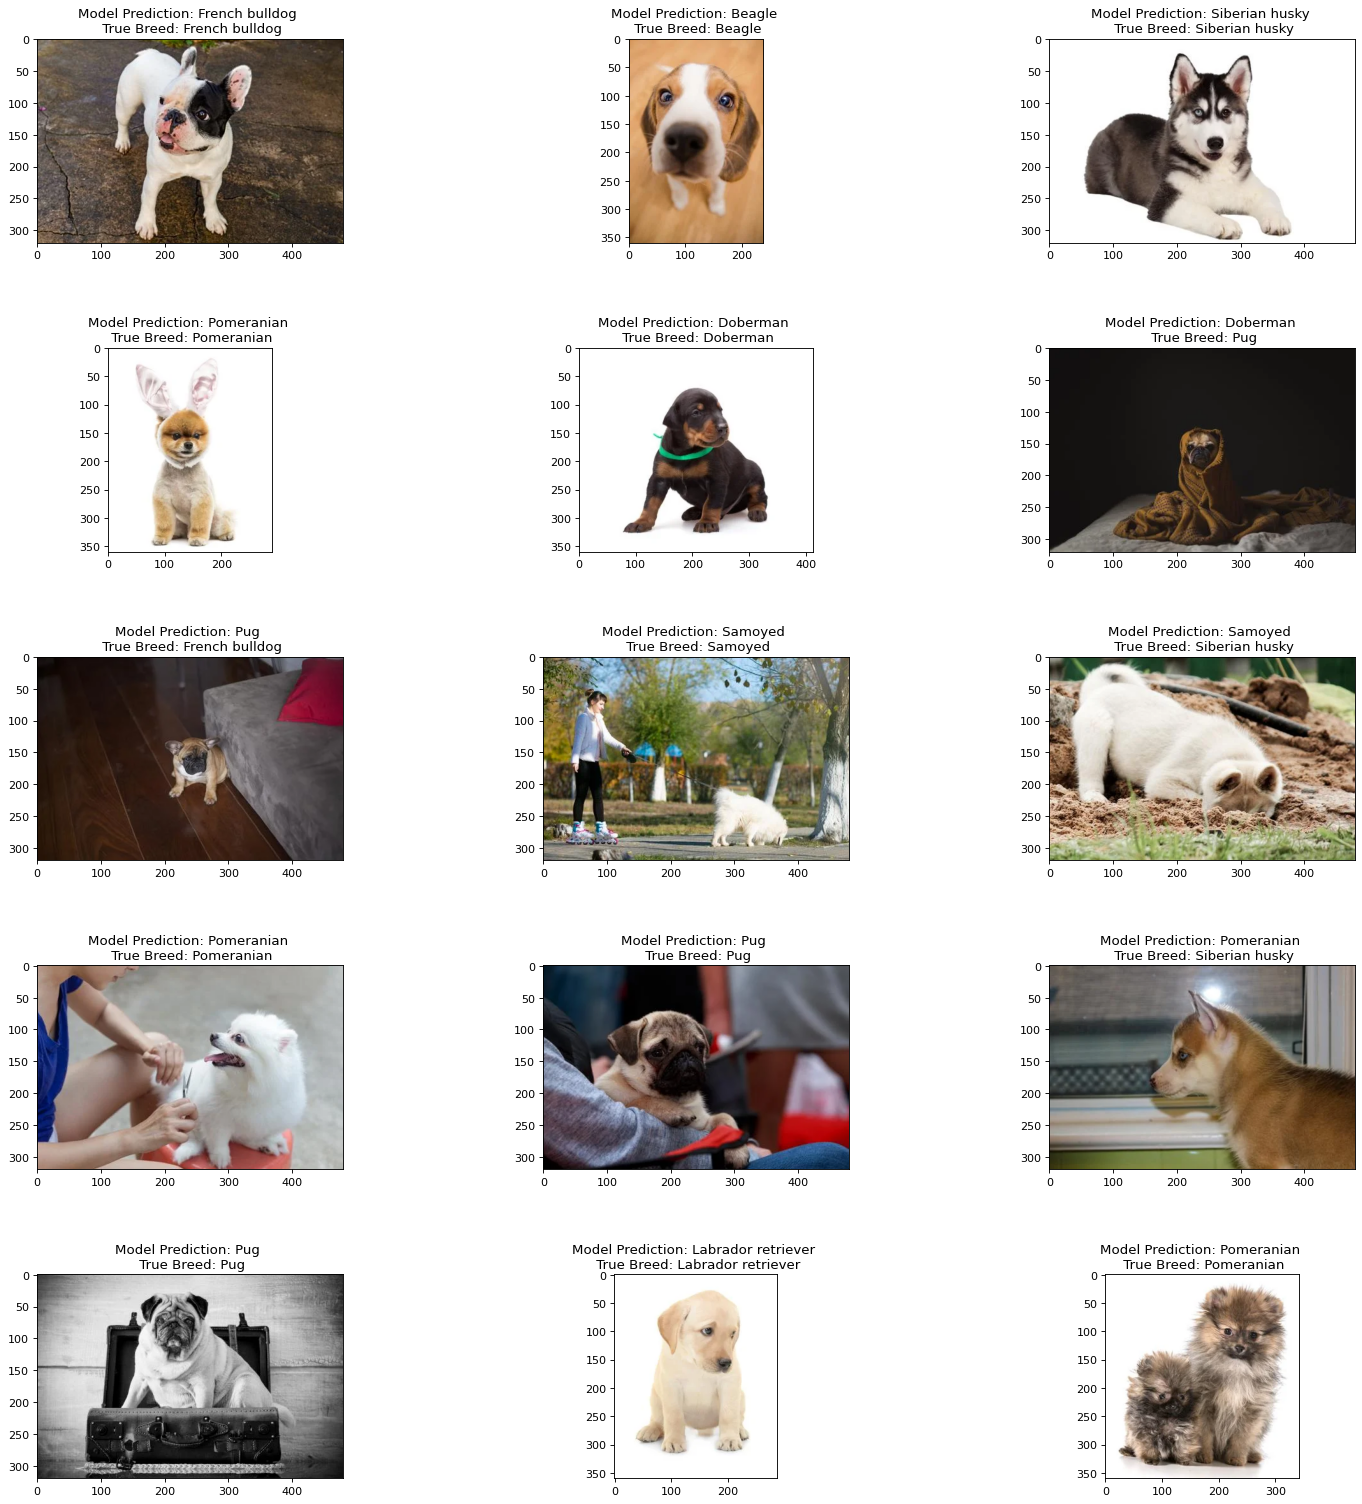

In [185]:
display_15_images(paths,image_breed,predictions)